# Markovian Adapted OT for Black–Scholes Processes
 
**Overview:**  
In this notebook we simulate two Black–Scholes processes with different parameters:
 
- **Process X:**  
$$
  dX_t = \mu_1 X_t\,dt + \sigma_1 X_t\,dW_t,\quad X_0=1,
  $$
   with, for example, $\mu_1=0.05$ and $\sigma_1=0.2$.

- **Process Y:**  
  $$
    dY_t = \mu_2 Y_t\,dt + \sigma_2 Y_t\,dW_t,\quad Y_0=1,
    $$
  with, for example, $\mu_2=0.03$ and $\sigma_2=0.3$.
 
**Setup:**  
- **Time Discretization:** $T=20$ steps with $dt=1/20$ (so total time equals 1).  
- **Quantization Grid:** 0.15  
- **Markovian Adapted OT:** The conditional measure construction and backward induction solver (markovian versions) are imported from your module.
- **Sample Sizes:** We compare performance for sample sizes 1000, 2000, 3000, 4000, and 5000 (with 10 runs per size).
 
For each run, the two processes are simulated (using independent random seeds), their paths are “adapted” via grid quantization, and the Markovian adapted Wasserstein squared distance is computed.

**Outputs:**  
- Aggregated results (mean and standard deviation of AW₂² and computation time) versus sample size.
- Plots for convergence of the computed adapted distance and computation time.


In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

# Set up module paths (adjust as needed)
notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import your custom functions (including the markovian solvers)
from optimal_code.utils import *
from optimal_code.optimal_solver import *
from optimal_code.optimal_solver_markov import *

from trees.build_trees_from_paths import *
from trees.treeVisualization import *
from adapted_empirical_measure.AEM_grid import *

## Black–Scholes Simulation Function

The following function simulates geometric Brownian motion using the exact solution.
For $t=0,\ldots,T$ with step size $dt$:

$$
X_{t} = X_{t-1}\exp\Big((\mu-\frac{1}{2}\sigma^2)dt + \sigma\sqrt{dt}\,Z_t\Big),
$$

where $Z_t\sim \mathcal{N}(0,1)$.

In [2]:
def bs_simulation(n_sample, T, mu, sigma, dt, seed):
    np.random.seed(seed)
    # Initialize: (T+1, n_sample)
    X = np.zeros((T+1, n_sample))
    X[0, :] = 1.0  # initial condition
    for t in range(1, T+1):
        Z = np.random.normal(size=n_sample)
        X[t, :] = X[t-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return X

In [25]:
# Parameters for process X
mu1 = 0.5
sigma1 = 0.15 #safe asset

# Parameters for process Y
mu2 = 0.12
sigma2 = 0.5 #volatile asset

T = 12
dt = 1/12

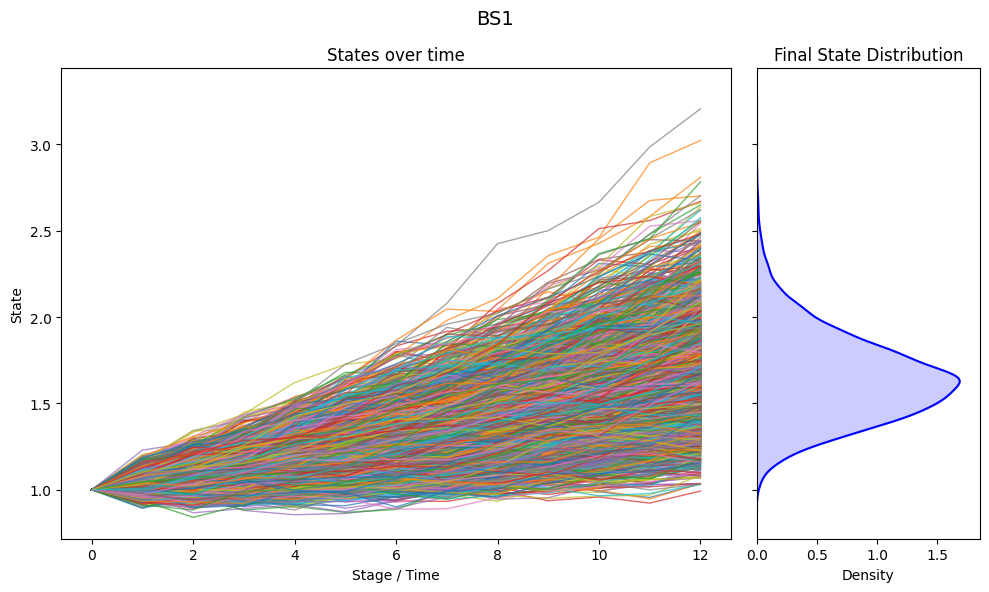

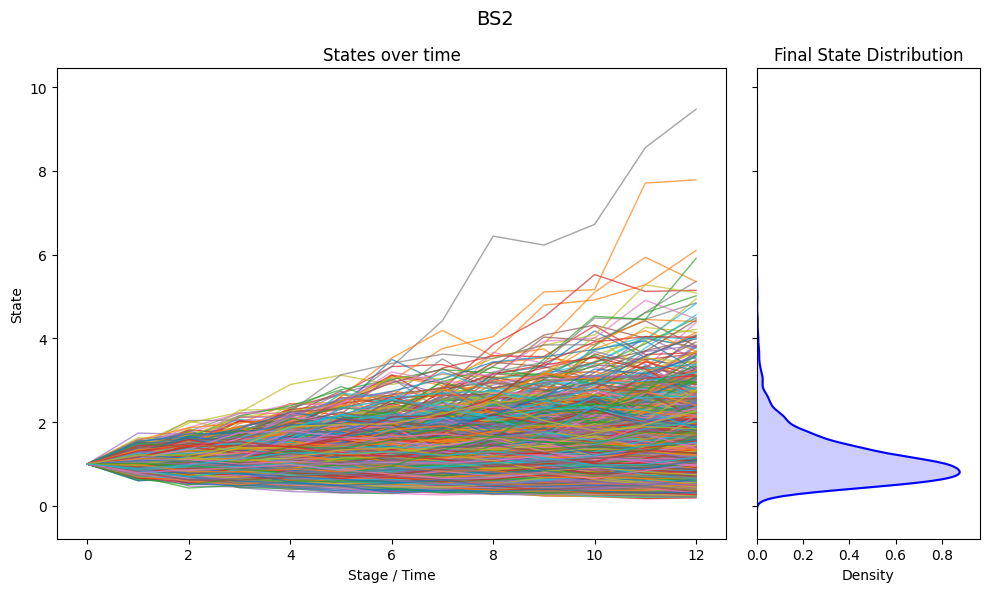

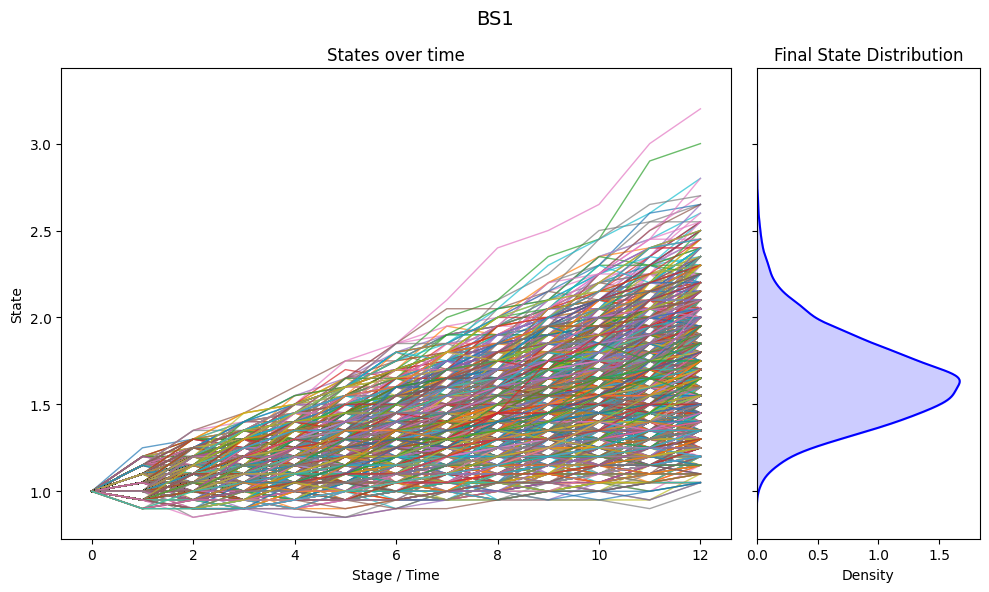

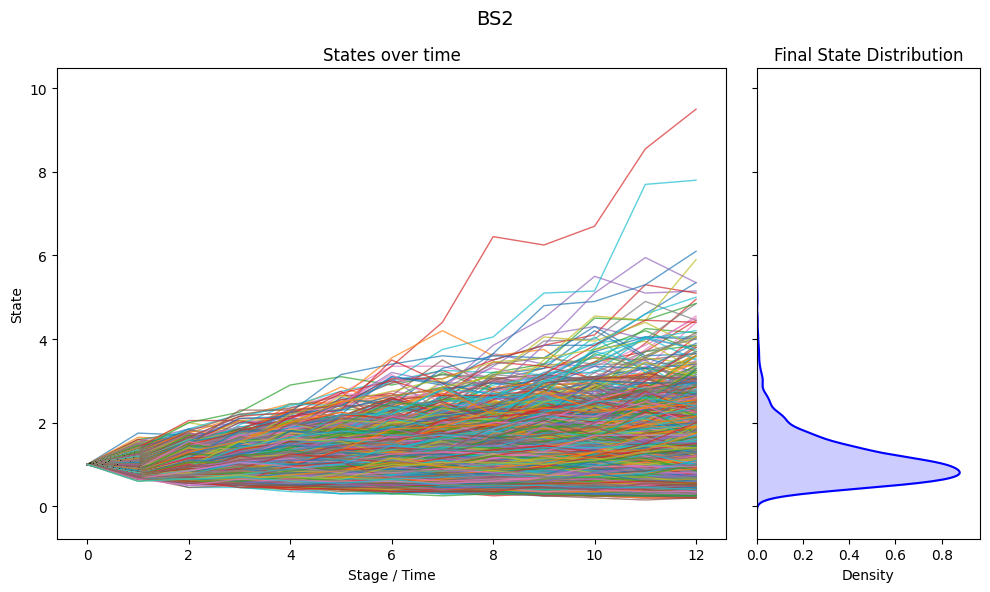

In [28]:
n_sample = 5000
seed = 44

X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)

iid_weights = np.full(n_sample, 1 / n_sample)

root = build_tree_from_paths(X.T, iid_weights)
visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="BS1",
)

root = build_tree_from_paths(Y.T, iid_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="BS2",
)

fixed_grid = 0.05

new_sample_paths, new_weights = uniform_empirical_grid_measure(X.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="BS1",
)

new_sample_paths, new_weights = uniform_empirical_grid_measure(Y.T, fixed_grid, use_weights=True) # Grid with number of grid points as in papers [0,1] divided into: 1/N^r with R=1/(T+1).
root = build_tree_from_paths(new_sample_paths, new_weights)

visualize_big_tree(
    root,
    fig_size=(10, 6),
    title="BS2",
)

In [29]:



sample_sizes = [1000, 2000, 5000, 10000, 20000, 30000]
n_runs = 10

In [30]:
results = {}

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        # Generate two independent seeds
        seed = np.random.randint(10000)
        
        # Simulate the BS processes
        X = bs_simulation(n_sample, T, mu1, sigma1, dt, seed)
        Y = bs_simulation(n_sample, T, mu2, sigma2, dt, seed)
        
        # Convert to adapted paths using grid quantization (the function path2adaptedpath is assumed available)
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)
        
        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)
        
        # Build conditional measures (markovian)
        mu_x = qpath2mu_x(qX, markovian=True)
        nu_y = qpath2mu_x(qY, markovian=True)
        
        # Updated list representations now return 7 items:
        (mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn, v2q_x, mu_x_idx) = \
            list_repr_mu_x_markovian(mu_x, q2v)
        (nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn, v2q_y, nu_y_idx) = \
            list_repr_mu_x_markovian(nu_y, q2v)
        
        # Compute adapted Wasserstein squared distance using the updated parallel solver
        t_start = time.perf_counter()
        AW_2square = nested2_parallel_markovian(mu_x_cn, mu_x_v, mu_x_w, mu_x_idx,
                                                nu_y_cn, nu_y_v, nu_y_w, nu_y_idx,
                                                n_processes=42)
        elapsed = time.perf_counter() - t_start
        
        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f}s")
    
    results[n_sample] = {"distances": distances_runs, "times": times_runs}


Running experiments for sample size: 1000
Run 1: AW_2^2 = 2.0361, Time = 7.0676s
Run 2: AW_2^2 = 2.0382, Time = 7.0667s
Run 3: AW_2^2 = 2.0037, Time = 6.8736s
Run 4: AW_2^2 = 2.0042, Time = 6.9967s
Run 5: AW_2^2 = 2.1233, Time = 6.9613s
Run 6: AW_2^2 = 1.9965, Time = 6.9015s
Run 7: AW_2^2 = 2.0908, Time = 7.0103s
Run 8: AW_2^2 = 2.0624, Time = 7.2394s
Run 9: AW_2^2 = 2.1303, Time = 7.2653s
Run 10: AW_2^2 = 2.0827, Time = 7.3763s

Running experiments for sample size: 2000
Run 1: AW_2^2 = 2.0791, Time = 7.3300s
Run 2: AW_2^2 = 2.0806, Time = 7.4276s
Run 3: AW_2^2 = 2.0454, Time = 7.4352s
Run 4: AW_2^2 = 2.1085, Time = 7.4073s
Run 5: AW_2^2 = 2.0252, Time = 7.4690s
Run 6: AW_2^2 = 2.2188, Time = 7.5778s
Run 7: AW_2^2 = 1.9725, Time = 7.5126s
Run 8: AW_2^2 = 2.0487, Time = 7.5698s
Run 9: AW_2^2 = 2.0510, Time = 7.6158s
Run 10: AW_2^2 = 2.0531, Time = 7.5953s

Running experiments for sample size: 5000
Run 1: AW_2^2 = 2.0241, Time = 7.5165s
Run 2: AW_2^2 = 2.0207, Time = 7.5919s
Run 3: AW_2

Sample Size: 1000
  Mean AW_2^2: 2.0568 ± 0.0465
  Mean Time: 7.0759s ± 0.1575s

Sample Size: 2000
  Mean AW_2^2: 2.0683 ± 0.0608
  Mean Time: 7.4940s ± 0.0901s

Sample Size: 5000
  Mean AW_2^2: 2.0132 ± 0.0213
  Mean Time: 7.6430s ± 0.0581s

Sample Size: 10000
  Mean AW_2^2: 1.9989 ± 0.0153
  Mean Time: 7.7676s ± 0.0765s

Sample Size: 20000
  Mean AW_2^2: 1.9924 ± 0.0125
  Mean Time: 7.8420s ± 0.0416s

Sample Size: 30000
  Mean AW_2^2: 1.9938 ± 0.0101
  Mean Time: 7.9057s ± 0.0656s



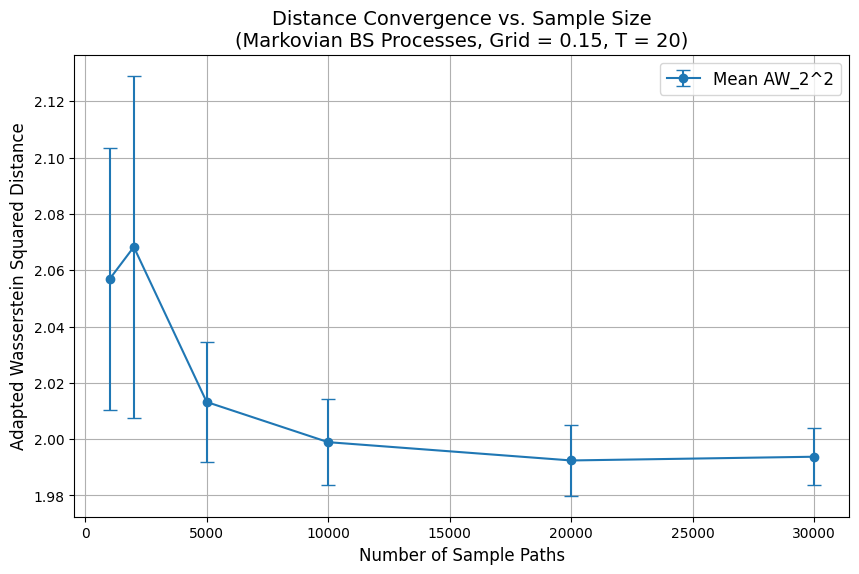

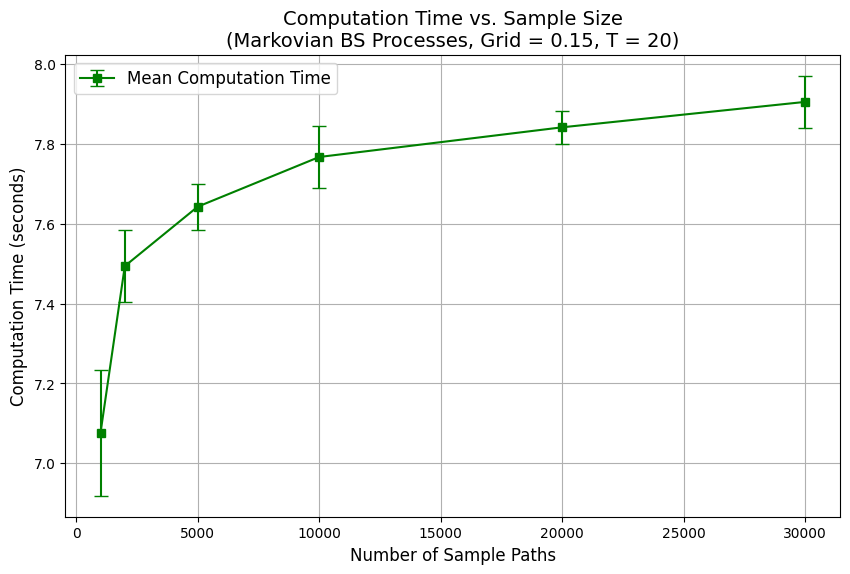

In [31]:
aggregated = {}
for n_sample in sorted(results.keys()):
    dists = results[n_sample]["distances"]
    times = results[n_sample]["times"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f}s ± {std_time:.4f}s\n")

# %% [markdown]
# ## Plotting the Results
# 
# We now plot:
# 1. Mean adapted Wasserstein squared distance vs. sample size (with error bars).
# 2. Computation time vs. sample size (with error bars).

# %% [code]
samples = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in samples]
std_distances = [aggregated[n]["std_distance"] for n in samples]
mean_times = [aggregated[n]["mean_time"] for n in samples]
std_times = [aggregated[n]["std_time"] for n in samples]

# Plot 1: Adapted AW_2^2 vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Markovian BS Processes, Grid = 0.15, T = 20)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time vs. Sample Size
plt.figure(figsize=(10, 6))
plt.errorbar(samples, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Markovian BS Processes, Grid = 0.15, T = 20)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()